![alt text](logo2.png "Title")

# Sentiment classification for movie reviews

Análisis de sentimiento mediante Recurrent Neural Networs usando el dataset publicado en http://ai.stanford.edu/~amaas/data/sentiment/ y procesado en un único .csv por https://www.kaggle.com/utathya/imdb-review-dataset

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("imdb_master.csv", encoding='latin-1', index_col = 0)
data.head()

,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [3]:
data_labeled = data[data.label != 'unsup']
del data

In [4]:
print("Número total de reviews --> ",len(data_labeled))
print("Número total de reviews positivas --> ",len(data_labeled[data_labeled["label"]=='pos']))
print("Número total de reviews negativas --> ",len(data_labeled[data_labeled["label"]=='neg']))

Número total de reviews -->  50000
Número total de reviews positivas -->  25000
Número total de reviews negativas -->  25000


In [5]:
y=data_labeled['label'].apply(lambda x: 0 if x == 'neg' else 1)

Para construir la estructura de nuestra red neuronal y evitar un tiempo excesivo en la fase de entrenamiento, dividiremos el conjunto data_labeled en dos conjuntos, uno large y otro small. Reservaremos un subconjunto de 40000 reviews para entrenar mejor nuestra red neuronal más adelante. Y ahora trabajaremos con un conjunto de 10000 reviews, de las cuales 2500 serán nuestro conjunto de datos de test.

In [6]:
from sklearn.model_selection import train_test_split

#Aislamos nuestro conjunto de test y de train
reviews_large, reviews_test, y_large, y_test = train_test_split(data_labeled['review'], y, test_size=2500, stratify=y)

#Extraemos un subconjunto de entrenamiento de solo 7500 reviews
reviews_rest, reviews_train, y_rest, y_train = train_test_split(reviews_large, y_large, test_size=7500, stratify=y_large)

### Procesamiento de texto 

In [7]:
import keras

C:\Users\Alfonso.arias\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
max_dic = 1000 #Número máximo de palabras que tendrá nuestro diccionario.

#El Tokenizer de Keras nos permite quedarnos con las palabras más frecuentes de todas las reviews
diccionario = keras.preprocessing.text.Tokenizer(num_words = max_dic)
diccionario.fit_on_texts(reviews_train)
#Ahora, por cada review obtenemos un vector de enteros indicando la palabra del diccionario
X_train = diccionario.texts_to_sequences(reviews_train)

#Realizamos lo mismo para el data set de test
X_test = diccionario.texts_to_sequences(reviews_test)

In [9]:
#Es recomendable que todas las reviews tengan la misma extensión de palabras
max_palabras=300
X_train=keras.preprocessing.sequence.pad_sequences(X_train,maxlen=max_palabras)
X_test=keras.preprocessing.sequence.pad_sequences(X_test,maxlen=max_palabras)

### Estructura RNN

In [10]:
red_neuronal=keras.models.Sequential()

#Primera capa tipo embedding. Creamos un embedding de dimensión 64
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))

#Segunda capa tipo LSTM con 32 neuronas. Devuelve un vector después de procesar la secuencia completa
red_neuronal.add(keras.layers.recurrent.LSTM(32))

#Última capa que devuelve un valor entre 0 y 1
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))

red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 76,449
Trainable params: 76,449
Non-trainable params: 0
_________________________________________________________________


In [11]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

In [12]:
history=red_neuronal.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
7500/7500 [==============================] - 40s 5ms/step - loss: 0.5555 - acc: 0.7092
Epoch 2/5
7500/7500 [==============================] - 39s 5ms/step - loss: 0.3805 - acc: 0.8371
Epoch 3/5
7500/7500 [==============================] - 40s 5ms/step - loss: 0.3499 - acc: 0.8527
Epoch 4/5
7500/7500 [==============================] - 39s 5ms/step - loss: 0.2991 - acc: 0.8751
Epoch 5/5
7500/7500 [==============================] - 39s 5ms/step - loss: 0.3403 - acc: 0.8532


In [13]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=pd.DataFrame({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1] },index=['LSTM-1hl'])
print(df)

2500/2500 [==============================] - 3s 1ms/step
Test loss 0.42026921396255495
Test accuracy 0.8096
          testAccuracy  testLoss  trainAccuracy  trainLoss
LSTM-1hl        0.8096  0.420269         0.8532   0.340296


Observamos que la precisión de nuestro conjunto de entrenamiento es mucho mayor que la de nuestro conjunto de test. Para solucionarlo, usaremos Dropout

In [14]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.45))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 76,449
Trainable params: 76,449
Non-trainable params: 0
_________________________________________________________________


In [15]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
history=red_neuronal.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
7500/7500 [==============================] - 44s 6ms/step - loss: 0.6063 - acc: 0.6672
Epoch 2/5
7500/7500 [==============================] - 43s 6ms/step - loss: 0.4827 - acc: 0.7801
Epoch 3/5
7500/7500 [==============================] - 44s 6ms/step - loss: 0.4402 - acc: 0.8053
Epoch 4/5
7500/7500 [==============================] - 43s 6ms/step - loss: 0.4511 - acc: 0.7985
Epoch 5/5
7500/7500 [==============================] - 43s 6ms/step - loss: 0.4201 - acc: 0.8157


In [16]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1]},name='LSTM-1hl-drop'))
print(df)

2500/2500 [==============================] - 3s 1ms/step
Test loss 0.46325392713546754
Test accuracy 0.7912
               testAccuracy  testLoss  trainAccuracy  trainLoss
LSTM-1hl             0.8096  0.420269       0.853200   0.340296
LSTM-1hl-drop        0.7912  0.463254       0.815733   0.420051


Observamos que no se obtiene tanto overfitting. Vamos a añadir otro LSTM layer manteniendo los dropout.

In [18]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.45,return_sequences=True))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.45))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 300, 32)           12416     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 84,769
Trainable params: 84,769
Non-trainable params: 0
_________________________________________________________________


In [19]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
history=red_neuronal.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
7500/7500 [==============================] - 101s 14ms/step - loss: 0.5797 - acc: 0.6812
Epoch 2/5
7500/7500 [==============================] - 106s 14ms/step - loss: 0.4642 - acc: 0.7869
Epoch 3/5
7500/7500 [==============================] - 98s 13ms/step - loss: 0.4376 - acc: 0.7981
Epoch 4/5
7500/7500 [==============================] - 97s 13ms/step - loss: 0.4072 - acc: 0.8220
Epoch 5/5
7500/7500 [==============================] - 81s 11ms/step - loss: 0.3965 - acc: 0.8284


In [20]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1]},name='LSTM-2hl-drop'))
print(df)

2500/2500 [==============================] - 7s 3ms/step
Test loss 0.4397216781616211
Test accuracy 0.8024
               testAccuracy  testLoss  trainAccuracy  trainLoss
LSTM-1hl             0.8096  0.420269       0.853200   0.340296
LSTM-1hl-drop        0.7912  0.463254       0.815733   0.420051
LSTM-2hl-drop        0.8024  0.439722       0.828400   0.396510


Usaremos ahora BRNN

In [21]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.Bidirectional(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.45)))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 88,897
Trainable params: 88,897
Non-trainable params: 0
_________________________________________________________________


In [22]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
history=red_neuronal.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
7500/7500 [==============================] - 103s 14ms/step - loss: 0.6150 - acc: 0.6576
Epoch 2/5
7500/7500 [==============================] - 89s 12ms/step - loss: 0.5000 - acc: 0.7685
Epoch 3/5
7500/7500 [==============================] - 97s 13ms/step - loss: 0.4552 - acc: 0.7984
Epoch 4/5
7500/7500 [==============================] - 110s 15ms/step - loss: 0.4330 - acc: 0.8073
Epoch 5/5
7500/7500 [==============================] - 105s 14ms/step - loss: 0.4350 - acc: 0.8036


In [23]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1]},name='BRNN-1hl-drop'))
print(df)

2500/2500 [==============================] - 6s 2ms/step
Test loss 0.4912445330619812
Test accuracy 0.764
               testAccuracy  testLoss  trainAccuracy  trainLoss
LSTM-1hl             0.8096  0.420269       0.853200   0.340296
LSTM-1hl-drop        0.7912  0.463254       0.815733   0.420051
LSTM-2hl-drop        0.8024  0.439722       0.828400   0.396510
BRNN-1hl-drop        0.7640  0.491245       0.803600   0.435031


In [24]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.Bidirectional(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.45,return_sequences=True)))
red_neuronal.add(keras.layers.Bidirectional(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.45)))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300, 64)           24832     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 113,729
Trainable params: 113,729
Non-trainable params: 0
_________________________________________________________________


In [25]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
history=red_neuronal.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
7500/7500 [==============================] - 195s 26ms/step - loss: 0.5906 - acc: 0.6719
Epoch 2/5
7500/7500 [==============================] - 187s 25ms/step - loss: 0.4659 - acc: 0.7849
Epoch 3/5
7500/7500 [==============================] - 187s 25ms/step - loss: 0.4203 - acc: 0.8149
Epoch 4/5
7500/7500 [==============================] - 186s 25ms/step - loss: 0.4127 - acc: 0.8236
Epoch 5/5
7500/7500 [==============================] - 181s 24ms/step - loss: 0.4013 - acc: 0.8267


In [26]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1]},name='BRNN-2hl-drop'))
print(df)

2500/2500 [==============================] - 14s 6ms/step
Test loss 0.5054503587722778
Test accuracy 0.7576
               testAccuracy  testLoss  trainAccuracy  trainLoss
LSTM-1hl             0.8096  0.420269       0.853200   0.340296
LSTM-1hl-drop        0.7912  0.463254       0.815733   0.420051
LSTM-2hl-drop        0.8024  0.439722       0.828400   0.396510
BRNN-1hl-drop        0.7640  0.491245       0.803600   0.435031
BRNN-2hl-drop        0.7576  0.505450       0.826667   0.401276


La precisión en nuestro test data set no mejora añadiendo un layer. Vamos a pasar a probar a entrenar un modelo con las 40000 reviews que no hemos usado junto con nuestro training set actual

In [10]:
#Debemos usar el dataset grande para definir un nuevo diccionario
diccionario_large = keras.preprocessing.text.Tokenizer(num_words = max_dic)
diccionario_large.fit_on_texts(reviews_train)
X_train_large = diccionario_large.texts_to_sequences(reviews_large)
X_test_large = diccionario_large.texts_to_sequences(reviews_test)

In [11]:
max_palabras=300
X_train_large=keras.preprocessing.sequence.pad_sequences(X_train_large,maxlen=max_palabras)
X_test_large=keras.preprocessing.sequence.pad_sequences(X_test_large,maxlen=max_palabras)

In [29]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.45))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 76,449
Trainable params: 76,449
Non-trainable params: 0
_________________________________________________________________


In [30]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
history=red_neuronal.fit(X_train_large, y_large, batch_size=32, epochs=5)

Epoch 1/5
47500/47500 [==============================] - 276s 6ms/step - loss: 0.5146 - acc: 0.7478
Epoch 2/5
47500/47500 [==============================] - 219s 5ms/step - loss: 0.4577 - acc: 0.7894
Epoch 3/5
47500/47500 [==============================] - 226s 5ms/step - loss: 0.4203 - acc: 0.8138
Epoch 4/5
47500/47500 [==============================] - 217s 5ms/step - loss: 0.4105 - acc: 0.8148
Epoch 5/5
47500/47500 [==============================] - 215s 5ms/step - loss: 0.3909 - acc: 0.8277


In [31]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1]},name='large-LSTM-1hl-drop'))
print(df)

2500/2500 [==============================] - 3s 1ms/step
Test loss 0.3597397653579712
Test accuracy 0.844
                     testAccuracy  testLoss  trainAccuracy  trainLoss
LSTM-1hl                   0.8096  0.420269       0.853200   0.340296
LSTM-1hl-drop              0.7912  0.463254       0.815733   0.420051
LSTM-2hl-drop              0.8024  0.439722       0.828400   0.396510
BRNN-1hl-drop              0.7640  0.491245       0.803600   0.435031
BRNN-2hl-drop              0.7576  0.505450       0.826667   0.401276
large-LSTM-1hl-drop        0.8440  0.359740       0.827663   0.390854


RNN con dos capas del tipo LSTM

In [32]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.45,return_sequences=True))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.45))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
lstm_11 (LSTM)               (None, 300, 32)           12416     
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 84,769
Trainable params: 84,769
Non-trainable params: 0
_________________________________________________________________


In [33]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
red_neuronal.fit(X_train_large, y_large, batch_size=32, epochs=5)

Epoch 1/5
47500/47500 [==============================] - 396s 8ms/step - loss: 0.4889 - acc: 0.7702
Epoch 2/5
47500/47500 [==============================] - 393s 8ms/step - loss: 0.4165 - acc: 0.8173
Epoch 3/5
47500/47500 [==============================] - 414s 9ms/step - loss: 0.4025 - acc: 0.8239
Epoch 4/5
47500/47500 [==============================] - 398s 8ms/step - loss: 0.3779 - acc: 0.8391
Epoch 5/5
47500/47500 [==============================] - 398s 8ms/step - loss: 0.3544 - acc: 0.8503


In [34]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1]},name='large-LSTM-2hl-drop'))
print(df)

2500/2500 [==============================] - 5s 2ms/step
Test loss 0.342758146572113
Test accuracy 0.858
                     testAccuracy  testLoss  trainAccuracy  trainLoss
LSTM-1hl                   0.8096  0.420269       0.853200   0.340296
LSTM-1hl-drop              0.7912  0.463254       0.815733   0.420051
LSTM-2hl-drop              0.8024  0.439722       0.828400   0.396510
BRNN-1hl-drop              0.7640  0.491245       0.803600   0.435031
BRNN-2hl-drop              0.7576  0.505450       0.826667   0.401276
large-LSTM-1hl-drop        0.8440  0.359740       0.827663   0.390854
large-LSTM-2hl-drop        0.8580  0.342758       0.827663   0.390854


RNN con 3 capas del tipo LSTM

In [35]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.45,return_sequences=True))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.45,return_sequences=True))
red_neuronal.add(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.45))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
lstm_13 (LSTM)               (None, 300, 32)           12416     
_________________________________________________________________
lstm_14 (LSTM)               (None, 300, 32)           8320      
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_8 (Activation)    (None, 1)                 0         
Total params: 93,089
Trainable params: 93,089
Non-trainable params: 0
_________________________________________________________________


In [36]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
history=red_neuronal.fit(X_train_large, y_large, batch_size=32, epochs=5)

Epoch 1/5
47500/47500 [==============================] - 561s 12ms/step - loss: 0.4823 - acc: 0.7730
Epoch 2/5
47500/47500 [==============================] - 539s 11ms/step - loss: 0.4142 - acc: 0.8191
Epoch 3/5
47500/47500 [==============================] - 569s 12ms/step - loss: 0.3858 - acc: 0.8331
Epoch 4/5
47500/47500 [==============================] - 532s 11ms/step - loss: 0.3596 - acc: 0.8481
Epoch 5/5
47500/47500 [==============================] - 552s 12ms/step - loss: 0.3310 - acc: 0.8619


In [37]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1]},name='large-LSTM-3hl-drop'))
print(df)

2500/2500 [==============================] - 7s 3ms/step
Test loss 0.3202972860097885
Test accuracy 0.864
                     testAccuracy  testLoss  trainAccuracy  trainLoss
LSTM-1hl                   0.8096  0.420269       0.853200   0.340296
LSTM-1hl-drop              0.7912  0.463254       0.815733   0.420051
LSTM-2hl-drop              0.8024  0.439722       0.828400   0.396510
BRNN-1hl-drop              0.7640  0.491245       0.803600   0.435031
BRNN-2hl-drop              0.7576  0.505450       0.826667   0.401276
large-LSTM-1hl-drop        0.8440  0.359740       0.827663   0.390854
large-LSTM-2hl-drop        0.8580  0.342758       0.827663   0.390854
large-LSTM-3hl-drop        0.8640  0.320297       0.861874   0.330984


BRNN con todos los datos de entrenamiento

In [20]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.Bidirectional(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.45)))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 88,897
Trainable params: 88,897
Non-trainable params: 0
_________________________________________________________________


In [21]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
history=red_neuronal.fit(X_train_large, y_large, batch_size=32, epochs=5)

Epoch 1/5
47500/47500 [==============================] - 385s 8ms/step - loss: 0.5037 - acc: 0.7606
Epoch 2/5
47500/47500 [==============================] - 379s 8ms/step - loss: 0.4589 - acc: 0.7898
Epoch 3/5
47500/47500 [==============================] - 383s 8ms/step - loss: 0.4316 - acc: 0.8076
Epoch 4/5
47500/47500 [==============================] - 383s 8ms/step - loss: 0.4088 - acc: 0.8215
Epoch 5/5
47500/47500 [==============================] - 381s 8ms/step - loss: 0.3913 - acc: 0.8295


In [22]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1]},name='large-BRNN-1hl-drop'))
print(df)

2500/2500 [==============================] - 4s 2ms/step
Test loss 0.3377771860122681
Test accuracy 0.864
                     testAccuracy  testLoss  trainAccuracy  trainLoss
LSTM-1hl                   0.8096  0.420269       0.853200   0.340296
LSTM-1hl-drop              0.7912  0.463254       0.815733   0.420051
LSTM-2hl-drop              0.8024  0.439722       0.828400   0.396510
BRNN-1hl-drop              0.7640  0.491245       0.803600   0.435031
large-LSTM-1hl-drop        0.8440  0.359740       0.827663   0.390854
BRNN-2hl-drop              0.7576  0.505450       0.826667   0.401276
large-LSTM-2hl-drop        0.8580  0.342758       0.827663   0.390854
large-LSTM-3hl-drop        0.8640  0.320297       0.861874   0.330984
large-BRNN-1hl-drop        0.8640  0.337777       0.829453   0.391300


BRNN dos layers

In [23]:
red_neuronal=keras.models.Sequential()
red_neuronal.add(keras.layers.embeddings.Embedding(input_dim=max_dic, input_length=max_palabras, output_dim=64))
red_neuronal.add(keras.layers.Bidirectional(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.45,return_sequences=True)))
red_neuronal.add(keras.layers.Bidirectional(keras.layers.recurrent.LSTM(32,recurrent_dropout=0.45)))
red_neuronal.add(keras.layers.core.Dense(1))
red_neuronal.add(keras.layers.core.Activation('sigmoid'))
red_neuronal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300, 64)           24832     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 113,729
Trainable params: 113,729
Non-trainable params: 0
_________________________________________________________________


In [24]:
red_neuronal.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
history=red_neuronal.fit(X_train_large, y_large, batch_size=32, epochs=5)

Epoch 1/5
47500/47500 [==============================] - 739s 16ms/step - loss: 0.4829 - acc: 0.7707
Epoch 2/5
47500/47500 [==============================] - 785s 17ms/step - loss: 0.4207 - acc: 0.8138
Epoch 3/5
47500/47500 [==============================] - 747s 16ms/step - loss: 0.3746 - acc: 0.8408
Epoch 4/5
47500/47500 [==============================] - 729s 15ms/step - loss: 0.3122 - acc: 0.8708
Epoch 5/5
47500/47500 [==============================] - 731s 15ms/step - loss: 0.2826 - acc: 0.8839


In [25]:
validacion=red_neuronal.evaluate(X_test, y_test)
print("Test loss", validacion[0])
print("Test accuracy", validacion[1])
df=df.append(pd.Series({'testLoss': validacion[0], 'testAccuracy': validacion[1], 'trainLoss':history.history['loss'][-1], 'trainAccuracy':history.history['acc'][-1]},name='large-BRNN-2hl-drop'))
print(df)

2500/2500 [==============================] - 9s 3ms/step
Test loss 0.26430443735122683
Test accuracy 0.8932
                     testAccuracy  testLoss  trainAccuracy  trainLoss
LSTM-1hl                   0.8096  0.420269       0.853200   0.340296
LSTM-1hl-drop              0.7912  0.463254       0.815733   0.420051
LSTM-2hl-drop              0.8024  0.439722       0.828400   0.396510
BRNN-1hl-drop              0.7640  0.491245       0.803600   0.435031
large-LSTM-1hl-drop        0.8440  0.359740       0.827663   0.390854
BRNN-2hl-drop              0.7576  0.505450       0.826667   0.401276
large-LSTM-2hl-drop        0.8580  0.342758       0.827663   0.390854
large-LSTM-3hl-drop        0.8640  0.320297       0.861874   0.330984
large-BRNN-1hl-drop        0.8640  0.337777       0.829453   0.391300
large-BRNN-2hl-drop        0.8932  0.264304       0.883874   0.282644


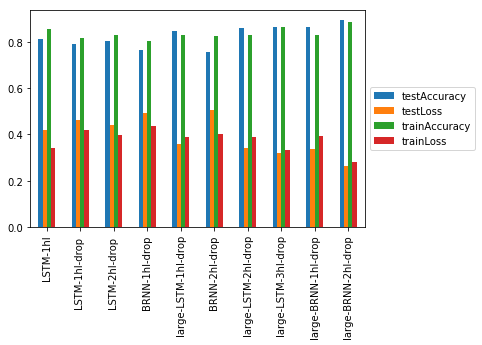

In [27]:
import matplotlib.pyplot as plt
plt.figure()
df.plot(kind='bar',legend=False).legend(loc='center left', bbox_to_anchor=(1, 0.5))